In [1]:
# Landing pad is always at coordinates (0,0). Coordinates are the first
# two numbers in state vector. Reward for moving from the top of the screen
# to landing pad and zero speed is about 100..140 points. If lander moves
# away from landing pad it loses reward back. Episode finishes if the lander
# crashes or comes to rest, receiving additional -100 or +100 points.
# Each leg ground contact is +10. Firing main engine is -0.3 points each frame.
# Solved is 200 points. Landing outside landing pad is possible. Fuel is
# infinite, so an agent can learn to fly and then land on its first attempt.
# Four discrete actions available: do nothing, fire left orientation engine,
# fire main engine, fire right orientation engine.


import gym
import random
from keras import Sequential
from collections import deque
from keras.layers import Dense
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from keras.activations import relu, linear

Using TensorFlow backend.


In [2]:
import numpy as np
env = gym.make('LunarLander-v2')
env.seed(0)
np.random.seed(0)

In [28]:
class DQN:

    """ Implementation of deep q learning algorithm """

    def __init__(self, action_space, state_space):

        self.action_space = action_space
        self.state_space = state_space
        self.epsilon = 1.0
        self.gamma = .99
        self.batch_size = 64
        self.epsilon_min = .01
        self.lr = 0.001
        self.epsilon_decay = .996
        self.memory = deque(maxlen=1000000)
        self.model = self.build_model()

    def build_model(self):

        model = Sequential()
        model.add(Dense(150, input_dim=self.state_space, activation=relu))
        model.add(Dense(120, activation=relu))
        model.add(Dense(self.action_space, activation=linear))
        model.compile(loss='mse', optimizer=Adam(lr=self.lr))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):

        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_space)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])
    def save(self):
        self.model.save("model.h5")

    def replay(self):

        if len(self.memory) < self.batch_size:
            return

        minibatch = random.sample(self.memory, self.batch_size)
        states = np.array([i[0] for i in minibatch])
        #print("states",states)
        actions = np.array([i[1] for i in minibatch])
        #print("actions",actions.shape)
        rewards = np.array([i[2] for i in minibatch])
        #print("reward",rewards.shape)
        next_states = np.array([i[3] for i in minibatch])
        #print("Next States",next_states)
        dones = np.array([i[4] for i in minibatch])
        #print("dones",dones.shape)

        states = np.squeeze(states)
        next_states = np.squeeze(next_states)
        #print(next_states.shape)

        targets = rewards + self.gamma*(np.amax(self.model.predict_on_batch(next_states), axis=1))*(1-dones)
        targets_full = self.model.predict_on_batch(states)
        #print(targets)
        ind = np.array([i for i in range(self.batch_size)])
        #print("ind",ind.shape)
        targets_full[[ind], [actions]] = targets
        #print("target",targets_full.shape)

        self.model.fit(states, targets_full, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


In [29]:
def train_dqn(episode):
  loss=[]
  agent = DQN(env.action_space.n, env.observation_space.shape[0])
  for e in range(episode):
    state = env.reset()
    #print(state.shape)
    #print(state)
    state = np.reshape(state, (1, 8))
    #print(state.shape)
    #print(state)
    score = 0
    max_steps = 3000
    for i in range(max_steps):
      action = agent.act(state)
      env.render()
      next_state, reward, done, _ = env.step(action)
      score += reward
      next_state = np.reshape(next_state, (1, 8))
      agent.remember(state, action, reward, next_state, done)
      state = next_state
      agent.replay()
      #print("done",done)
      if done:
        print("episode: {}/{}, score: {}".format(e, episode, score))
        break

    loss.append(score)
    # Average score of last 100 episode
    is_solved = np.mean(loss[-100:])
    if is_solved > 200:
      agent.save()
      print('\n Task Completed! and saved the model\n')
      break
    #print("Average over last 100 episode: {0:.2f} \n".format(is_solved))
    #print(loss)
  return loss

episode: 0/500, score: -126.37173423011826
episode: 1/500, score: -85.36905703727999
episode: 2/500, score: -333.56845610292214
episode: 3/500, score: -587.0157782202523
episode: 4/500, score: -344.5975593069692
episode: 5/500, score: -228.67797297850908
episode: 6/500, score: -223.5396724150159
episode: 7/500, score: -120.15027772457037
episode: 8/500, score: -206.11368690442015
episode: 9/500, score: -514.2145880033295
episode: 10/500, score: -183.48058460383322
episode: 11/500, score: -140.67049335381952
episode: 12/500, score: -159.7884427890886
episode: 13/500, score: -16.994664272546327
episode: 14/500, score: -18.02694925312125
episode: 15/500, score: -13.928264812609353
episode: 16/500, score: -51.449489472787846
episode: 17/500, score: -36.14062702977094
episode: 18/500, score: -234.40905391055549
episode: 19/500, score: -38.04991447795388
episode: 20/500, score: -28.466551275565344
episode: 21/500, score: -97.76863517700563
episode: 22/500, score: -61.62804907412503
episode: 

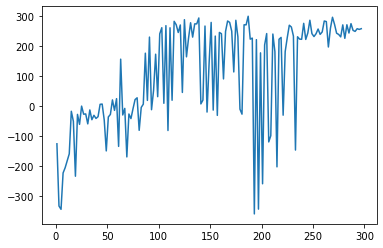

In [30]:
if __name__ == '__main__':
    episodes = 500
    loss = train_dqn(episodes)
    env.close()
    plt.plot([i+1 for i in range(0, len(loss), 2)], loss[::2])
    plt.show()